In [27]:
import os
import re
import glob
import struct
from os import makedirs

import numpy as np
from numpy import asarray
from numpy import zeros
from nltk.stem.porter import *


import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Reshape, Conv2D, MaxPool2D, Dense, Dropout,BatchNormalization, Flatten, Embedding, Concatenate, Conv1D
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras import regularizers
from keras import backend as K
from keras.models import load_model


import matplotlib.pyplot as plt


Load the Dataset


In [3]:
os.chdir("train")

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [4]:
names = ['TweetID', 'Sentiment', 'Tweet']

train = pd.read_csv('/content/train/combined_csv.csv')

train.head()

,Column1,Column2,Column3
0,2.492980e+17,positive,i'm done writing code for the week! Looks like...
1,2.820310e+17,neutral,dec 21st 2012 will be know not as the end of t...
2,2.208800e+17,negative,"@MacMiller hate my life, because i can't see y..."
3,2.240010e+17,positive,Checked out Our Lady Peace at Bluesfest tonigh...
4,2.557130e+17,positive,Hello from the Foundation Trekkers! We're up i...


Data Preprocessing

In [5]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

def clean_tweets(frame, column_name):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words

  return frame

In [6]:
train_set = clean_tweets(train, 'Column3')
train_set.head()

,Column1,Column2,Column3,Tweet_Clean_Text
0,2.492980e+17,positive,i'm done writing code for the week! Looks like...,i m done writing code for the week Looks like ...
1,2.820310e+17,neutral,dec 21st 2012 will be know not as the end of t...,dec st will be know not as the end of the worl...
2,2.208800e+17,negative,"@MacMiller hate my life, because i can't see y...",hate my life because i can t see you at the r...
3,2.240010e+17,positive,Checked out Our Lady Peace at Bluesfest tonigh...,Checked out Our Lady Peace at Bluesfest tonigh...
4,2.557130e+17,positive,Hello from the Foundation Trekkers! We're up i...,Hello from the Foundation Trekkers We re up in...


In [7]:
train_set["Sentiment_Value"] = train_set["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
label = to_categorical(train_set["Sentiment_Value"], 3)
train_set

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,2.492980e+17,positive,i'm done writing code for the week! Looks like...,i m done writing code for the week Looks like ...,1
1,2.820310e+17,neutral,dec 21st 2012 will be know not as the end of t...,dec st will be know not as the end of the worl...,0
2,2.208800e+17,negative,"@MacMiller hate my life, because i can't see y...",hate my life because i can t see you at the r...,2
3,2.240010e+17,positive,Checked out Our Lady Peace at Bluesfest tonigh...,Checked out Our Lady Peace at Bluesfest tonigh...,1
4,2.557130e+17,positive,Hello from the Foundation Trekkers! We're up i...,Hello from the Foundation Trekkers We re up in...,1
...,...,...,...,...,...
49710,6.409160e+17,positive,I need to become a celebrity so I can just be ...,I need to become a celebrity so I can just be ...,1
49711,6.410380e+17,positive,Snoop dogg may be the funniest human alive,Snoop dogg may be the funniest human alive,1
49712,6.412190e+17,neutral,I'm only ok with 3rd floor playing Snoop Dogg ...,I m only ok with rd floor playing Snoop Dogg t...,0
49713,6.413490e+17,positive,SNOOP DOGG AKA SNOOPADELIC friday friday only ...,SNOOP DOGG AKA SNOOPADELIC friday friday only ...,1


In [8]:
train_set['Column2'].value_counts()

neutral     22274
positive    19688
negative     7753
Name: Column2, dtype: int64

In [9]:
y_labels = train_set['Sentiment_Value']
y_labels.shape

(49715,)

In [10]:
train['l'] = train_set['Tweet_Clean_Text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(train.l.mean()))
print("max length of sentence: " + str(train.l.max()))
print("std dev length of sentence: " + str(train.l.std()))

mean length of sentence: 20.210278587951322
max length of sentence: 47.0
std dev length of sentence: 5.264851918216882


In [11]:
sequence_length = 47 #using the maximum length 

In [12]:
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(train_set['Tweet_Clean_Text'].values)

X = tokenizer.texts_to_sequences(train_set['Tweet_Clean_Text'].values)
X = pad_sequences(X, sequence_length)
x_train = X

print("training size " + str(len(x_train)))

voc_size = len(tokenizer.word_index) + 1
print("Vocab size: ", voc_size)
print("Input shape: ", x_train.shape)
print("Y_shape: " , y_labels.shape)

training size 49715
Vocab size:  42660
Input shape:  (49715, 47)
Y_shape:  (49715,)


Spliting the dataset

In [13]:
X_train, X_dev, Y_train, Y_dev = train_test_split(x_train, y_labels, test_size=0.15, shuffle=True, random_state=10)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


GloVe Embedding

In [15]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/twitter/glove.twitter.27B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [16]:
embedding_dim = 200
embedding_matrix = np.zeros((voc_size, embedding_dim))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

**Stacked CNN Predictions Ensemble**

In [17]:
Y_train_cat = to_categorical(Y_train, 3)
Y_dev_cat = to_categorical(Y_dev, 3)

In [18]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [19]:
Metrics = [
           keras.metrics.CategoricalAccuracy(name = 'categorical_accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics
]

In [20]:
def fit_model(filter_size):
  #define the model
  model = Sequential()
  model.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model.add(Reshape((sequence_length, embedding_dim, 1)))
  model.add(Conv2D(256, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(units=352, activation='relu'))
  model.add(Dense(units=3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  #fit the model
  history = model.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, verbose=2)
  return model

In [21]:
filter_sizes = [3,5,7,9,11]

n_members = 5
for i in range(n_members):
	# fit model
	model = fit_model(filter_sizes[i])
	# save model
	filename = 'models/model_' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

Epoch 1/20
42/42 - 14s - loss: 1.5600 - categorical_accuracy: 0.4520 - precision: 0.5000 - recall: 0.0024 - f1_metrics: 0.0045 - val_loss: 1.0554 - val_categorical_accuracy: 0.4490 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_metrics: 0.0000e+00
Epoch 2/20
42/42 - 5s - loss: 1.0161 - categorical_accuracy: 0.5590 - precision: 0.6657 - recall: 0.2228 - f1_metrics: 0.3053 - val_loss: 1.0633 - val_categorical_accuracy: 0.5202 - val_precision: 0.5858 - val_recall: 0.3304 - val_f1_metrics: 0.4221
Epoch 3/20
42/42 - 5s - loss: 1.0282 - categorical_accuracy: 0.5890 - precision: 0.6358 - recall: 0.4621 - f1_metrics: 0.5343 - val_loss: 1.0128 - val_categorical_accuracy: 0.6035 - val_precision: 0.6423 - val_recall: 0.5225 - val_f1_metrics: 0.5818
Epoch 4/20
42/42 - 5s - loss: 1.0358 - categorical_accuracy: 0.5989 - precision: 0.6437 - recall: 0.4910 - f1_metrics: 0.5562 - val_loss: 1.0140 - val_categorical_accuracy: 0.6030 - val_precision: 0.6417 - val_recall: 0.5349 - val_f1_met

In [33]:
# stacked generalization with neural net meta model on blobs dataset
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax

# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename,custom_objects={'f1':f1_metrics,'precision':precision_score,'recall':recall_score})
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	h1 = Dropout(0.2)(hidden)
	h2 = BatchNormalization()(h1)
	output = Dense(3, activation='softmax')(h2)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
	return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	newdev = [X_dev for _ in range(len(model.input))]
	# encode output data
	#inputy_enc = to_categorical(inputy)
	# fit model
	history=model.fit(X, inputy, epochs=100, verbose=2,validation_data=(newdev, Y_dev_cat))
	return history
	#model.fit(X, inputy, epochs=20, verbose=2)



# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)


# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
history = fit_stacked_model(stacked_model, X_train,Y_train_cat)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X_dev)
for i in range(yhat.shape[0]):
  emo=np.where(yhat[i]==max(yhat[i]))[0][0]
  yhat[i][emo]=1
  yhat[i][(emo+1)%3]=0
  yhat[i][(emo+2)%3]=0
#yhat = np.array(yhat, dtype='int64')
acc = accuracy_score(Y_dev_cat, yhat)
print('Stacked Test Accuracy: %.3f' % acc)



>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models
Epoch 1/100
1321/1321 - 14s - loss: 1.9811 - categorical_accuracy: 0.6387 - precision: 0.6892 - recall: 0.5398 - f1: 0.5985 - val_loss: 1.9365 - val_categorical_accuracy: 0.6499 - val_precision: 0.6897 - val_recall: 0.5814 - val_f1: 0.6294
Epoch 2/100
1321/1321 - 11s - loss: 1.9393 - categorical_accuracy: 0.6561 - precision: 0.7055 - recall: 0.5663 - f1: 0.6273 - val_loss: 1.9355 - val_categorical_accuracy: 0.6494 - val_precision: 0.6908 - val_recall: 0.5676 - val_f1: 0.6212
Epoch 3/100
1321/1321 - 11s - loss: 1.9372 - categorical_accuracy: 0.6549 - precision: 0.7034 - recall: 0.5635 - f1: 0.6249 - val_loss: 1.9329 - val_categorical_accuracy: 0.6482 - val_precision: 0.6915 - val_recall: 0.5750 - val_f1: 0.6264
Epoch 4/100
1321/1321 - 11s - loss: 1.9357 - categorical_accuracy: 0.6534 - precision: 0.7005 - recall: 0.5644 - f1: 0.6242 - val_loss

In [34]:
def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

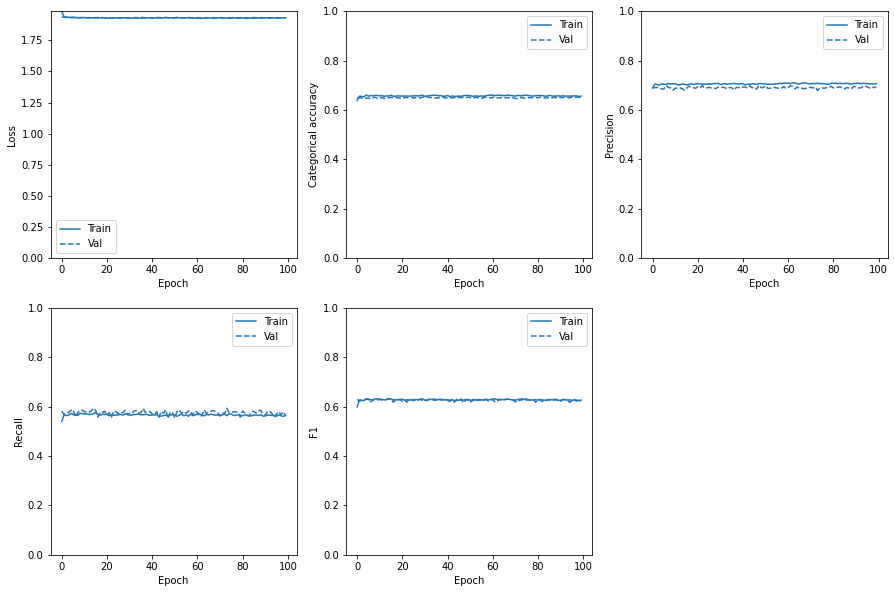

In [35]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 15, 10
plot_metrics(history)